# pix2pix: Image-to-image translation with a conditional GAN

In [ ]:
import os

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.utils as vutils
import torchvision
from barbar import Bar
from torchvision.models import resnet18
import pathlib
import json


from matplotlib import pyplot as plt
from IPython import display

In [26]:
base_dir = os.getcwd()
dataset_dir = os.path.abspath(os.path.join(base_dir, "..", "train"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
sample_image_path = os.path.join(dataset_dir, 'images', 'guatemala-volcano_00000013_post_disaster.png')

# Check if the file exists
if not os.path.exists(sample_image_path):
    print(f"File not found: {sample_image_path}")
else:
    # Load the sample image
    sample_image = torchvision.io.read_image(sample_image_path)
    print(sample_image.shape)

torch.Size([3, 1024, 1024])


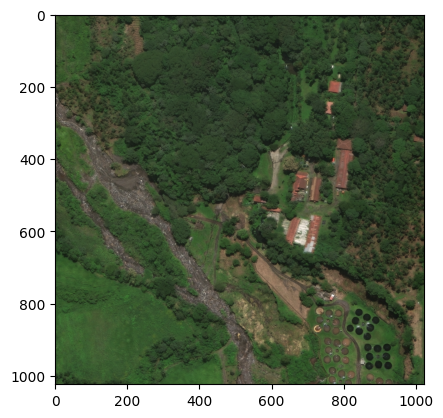

In [28]:
plt.figure()
plt.imshow(sample_image.permute(1, 2, 0).numpy())

Disaster types → index map: {'fire': 1, 'flooding': 2, 'wind': 3, 'earthquake': 4, 'tsunami': 5, 'volcano': 6}
Computed attr_dim = 7 (0 … 6)
Full-size pre/post pairs: 2799
Patches per pair: 16
Total (pre→post) patch-pairs in dataset: 44784
Pre-disaster image shape: torch.Size([16, 3, 256, 256])
Post-disaster image shape: torch.Size([16, 3, 256, 256])
Pre-disaster attribute: 0
Post-disaster attribute: 2
{'fire': 1, 'flooding': 2, 'wind': 3, 'earthquake': 4, 'tsunami': 5, 'volcano': 6}


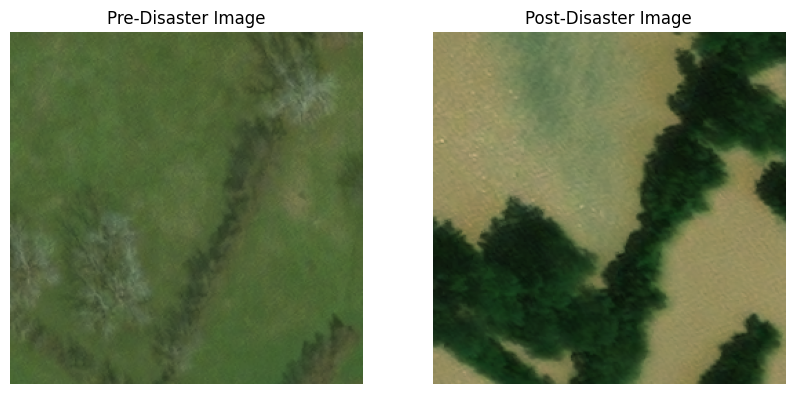

In [29]:
class DisasterDataset(Dataset):
    """
    Dataset for DisasterGAN: loads pre- and post-disaster image pairs and disaster-type labels.
    Expects a directory structure:
    root_dir/pre/<filename>
    root_dir/post/<filename>
    labels_dir/*_post_disaster.json
    """
    def __init__(self, root_dir, labels_dir, transform=None, patch_size=256):
        self.root_dir = root_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.patch_size = patch_size
        
        self.pre_images = sorted(pathlib.Path(root_dir).rglob('*_pre_disaster.png'))
        
        self.type2idx = {}
        self.labels   = {}
        for lf in pathlib.Path(labels_dir).rglob('*_post_disaster.json'):
            d = json.load(open(lf))
            t = d['metadata']['disaster_type']
            if t not in self.type2idx:
                self.type2idx[t] = len(self.type2idx) + 1
            # map the matching PNG filename to its code
            png_name = os.path.basename(lf).replace('.json', '.png')
            self.labels[png_name] = self.type2idx[t]
        
        self.samples = []
        for pre_path in self.pre_images:
            post_path = str(pre_path).replace('_pre_disaster', '_post_disaster')
            # Check if both pre and post images exist
            if os.path.exists(pre_path) and os.path.exists(post_path):
                for row in range(4):
                    for col in range(4):
                        self.samples.append((pre_path, post_path, row, col))
            else:
                print(f"Skipping missing image pair: {pre_path} or {post_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        pre_path, post_path, row, col = self.samples[idx]
        pre_img  = Image.open(pre_path).convert('RGB')
        post_img = Image.open(post_path).convert('RGB')
        # compute crop box
        left   = col * self.patch_size
        top    = row * self.patch_size
        right  = left + self.patch_size
        bottom = top  + self.patch_size
        pre_patch  = pre_img.crop((left, top, right, bottom))
        post_patch = post_img.crop((left, top, right, bottom))

        attr_pre  = 0
        attr_post = self.labels.get(os.path.basename(post_path), 0)

        if self.transform:
            pre_patch  = self.transform(pre_patch)
            post_patch = self.transform(post_patch)

        return pre_patch, post_patch, attr_pre, attr_post
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

image_dir = os.path.join(dataset_dir, 'images')
label_dir = os.path.join(dataset_dir, 'labels')
dataset = DisasterDataset(image_dir, label_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

# Add these two lines:
print("Disaster types → index map:", dataset.type2idx)
# highest assigned index:
max_label = max(dataset.type2idx.values()) if dataset.type2idx else 0
attr_dim  = max_label + 1
print(f"Computed attr_dim = {attr_dim} (0 … {max_label})")

print(f"Full-size pre/post pairs: {len(dataset.pre_images)}")
print(f"Patches per pair: 16")
print(f"Total (pre→post) patch-pairs in dataset: {len(dataset)}")


pre_image, post_image, c_att, c_p_att = next(iter(dataloader))

print(f"Pre-disaster image shape: {pre_image.shape}")
print(f"Post-disaster image shape: {post_image.shape}")
print(f"Pre-disaster attribute: {c_att[0]}")
print(f"Post-disaster attribute: {c_p_att[0]}")
print(dataset.type2idx)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Pre-Disaster Image")
plt.imshow(pre_image[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # De-normalize for visualization
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Post-Disaster Image")
plt.imshow(post_image[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # De-normalize for visualization
plt.axis("off")
plt.show()

Creating a Test Dataset Loader

Pre-disaster image shape: torch.Size([1, 3, 256, 256])
Post-disaster image shape: torch.Size([1, 3, 256, 256])


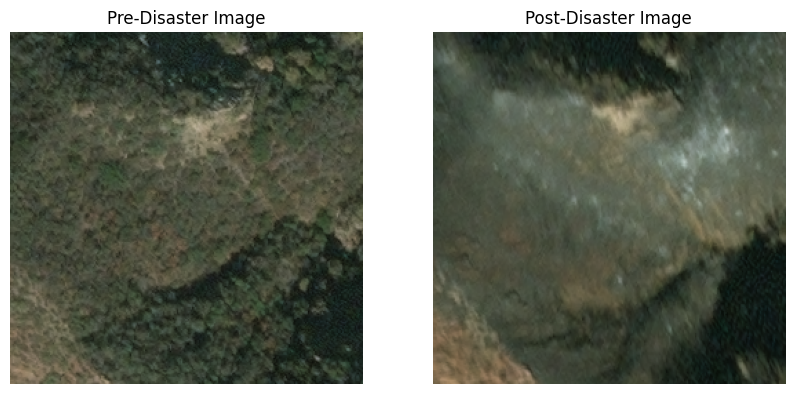

In [30]:
test_dir = os.path.abspath(os.path.join(base_dir, "..", "test"))

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

image_dir = os.path.join(test_dir, 'images')
label_dir = os.path.join(test_dir, 'labels')
test_dataset = DisasterDataset(image_dir, label_dir, transform=test_transform)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2
)

pre_image, post_image, _, _ = next(iter(test_dataloader))

print(f"Pre-disaster image shape: {pre_image.shape}")
print(f"Post-disaster image shape: {post_image.shape}")


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Pre-Disaster Image")
plt.imshow(pre_image[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # De-normalize for visualization
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Post-Disaster Image")
plt.imshow(post_image[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # De-normalize for visualization
plt.axis("off")
plt.show()


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, dropout=0.5):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Conv2d(channels, channels, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(channels),
        )

    def forward(self, x):
        return x + self.block(x)
    


class Generator(nn.Module):
    """
    conditional generator G: takes X and one-hot attr C (size=5),
    concatenates to 11-ch map, encodes, resblocks, and decodes to RGB
    """
    def __init__(self, img_channels=3, attr_dim=5):
        super().__init__()
        self.attr_dim = attr_dim
        self.res_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])
        # encode: 8→64→128→256
        self.enc = nn.Sequential(
            nn.Conv2d(img_channels+attr_dim,  64, 7,1,3), nn.InstanceNorm2d(64),  nn.ReLU(inplace=True),
            nn.Conv2d(64,128,4,2,1),           nn.InstanceNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128,256,4,2,1),          nn.InstanceNorm2d(256), nn.ReLU(inplace=True),
        )
        # decode: 256→128→64→3
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1), nn.InstanceNorm2d(128), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128,64,4,2,1), nn.InstanceNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64,3,7,1,3),           nn.Tanh(),
        )
        
    def forward(self, x, c):
        # build attribute map and concat
        B,C,H,W = x.shape[0], x.shape[1], x.shape[2], x.shape[3]
        c_onehot = F.one_hot(c, num_classes=self.attr_dim).float().to(x.device)
        c_map = c_onehot.view(B, -1, 1, 1).expand(B, self.attr_dim, H, W)
        h = self.enc(torch.cat([x, c_map], dim=1))
        h = self.res_blocks(h)
        return self.dec(h)

In [32]:
class Discriminator(nn.Module):
    """
    PatchGAN discriminator with source & auxiliary classifier heads
    """
    def __init__(self, in_channels=3, n_classes=5):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(in_channels,  64, 4,2,1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d( 64, 128, 4,2,1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4,2,1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4,2,1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512,1024, 4,2,1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 2048, 4,2,1), nn.LeakyReLU(0.2, inplace=True),
            
        )
        # real/fake
        self.src = nn.Conv2d(2048, 1, 3,1,1)
        # classification
        self.cls = nn.Conv2d(2048, n_classes, kernel_size=4, stride=1, padding=0)

    def forward(self, x):
        h = self.shared(x)
        out_src = torch.sigmoid(self.src(h))
        out_cls = self.cls(h).view(x.size(0), -1)  # global pool
        return out_src, out_cls

## Training


In [33]:
class TrainerStarGAN:
    def __init__(self, args, train_loader, test_loader, device):
        self.args = args
        self.train_loader = train_loader
        self.test_loader  = test_loader
        self.device = device
        self.writer = SummaryWriter(log_dir='./logs')
        self.checkpoint_dir = getattr(args, 'checkpoint_dir', './checkpoints')
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    def train(self):
        """Training the StarGAN model."""
        self.G             = Generator(img_channels=3,  attr_dim=args.attr_dim).to(device)
        self.G_reconstruct = Generator(img_channels=3,  attr_dim=args.attr_dim).to(device)
        self.D             = Discriminator(in_channels=6, n_classes=args.attr_dim).to(device)



        optimizer_ge = optim.Adam(
            self.G.parameters(),
            lr=self.args.lr_adam, betas=(0.5, 0.999)
        )
        optimizer_d  = optim.Adam(
            self.D.parameters(),
            lr=self.args.lr_adam, betas=(0.5, 0.999)
        )
        
        start_epoch = 0
        if getattr(self.args, 'resume', None):
            ckpt_path = self.args.resume
            if os.path.isfile(ckpt_path):
                ckpt = torch.load(ckpt_path, map_location=self.device)
                self.G.load_state_dict(ckpt['G'])
                self.G_reconstruct.load_state_dict(ckpt['G_reconstruct'])
                self.D.load_state_dict(ckpt['D'])
                optimizer_ge.load_state_dict(ckpt['optimizer_ge'])
                optimizer_d.load_state_dict(ckpt['optimizer_d'])
                start_epoch = ckpt['epoch'] + 1
                print(f"Resumed from checkpoint '{ckpt_path}' at epoch {start_epoch}")

        criterion = nn.BCELoss()
        classification_criterion = nn.CrossEntropyLoss()
        reconstruction_criterion = nn.L1Loss()
        # weights (λ_cls, λ_rec) from paper Sec. 4.2.1
        cls_weight = getattr(self.args, 'cls_weight', 1)
        recon_weight = getattr(self.args, 'recon_weight', 100.0)

        for epoch in range(start_epoch, self.args.num_epochs + 1):
            ge_losses = 0
            d_losses = 0
            
            if epoch % 10 == 0:
                # Save the model checkpoint
                print(f"Saving checkpoint at epoch {epoch}")
                ckpt = {
                    'epoch': epoch,
                    'G': self.G.state_dict(),
                    'G_reconstruct': self.G_reconstruct.state_dict(),
                    'D': self.D.state_dict(),
                    'optimizer_ge': optimizer_ge.state_dict(),
                    'optimizer_d': optimizer_d.state_dict(),
                }
                torch.save(ckpt, os.path.join(self.checkpoint_dir, f'ckpt_epoch{epoch}.pt'))

            for pre_image, post_image, c_d, c_p_att in Bar(self.train_loader):
                # Move data to device
                pre_image, post_image, c_d, c_p_att = (
                    pre_image.to(self.device),
                    post_image.to(self.device),
                    c_d.to(self.device),
                    c_p_att.to(self.device),
                )

                # ---------------------
                # Train Discriminator
                # ---------------------
                optimizer_d.zero_grad()

                real_pair = torch.cat([pre_image, post_image], dim=1)
                real_src, real_cls = self.D(real_pair)  # Discriminator output for Fake/True and classification of attribute
                y_real = torch.ones_like(real_src)
                loss_d_real = criterion(real_src, y_real) \
                            + cls_weight * classification_criterion(real_cls, c_p_att)
                
                # fake
                fake_post = self.G(pre_image, c_p_att).detach()
                fake_pair = torch.cat([post_image, fake_post], dim=1) # Focus on the post-disaster image
                fake_src, _ = self.D(fake_pair)
                y_fake = torch.zeros_like(fake_src)
                loss_d_fake = criterion(fake_src, y_fake)


                # Backpropagation for discriminator
                loss_d = (loss_d_real + loss_d_fake) / 2
                loss_d.backward()
                optimizer_d.step()

                # ---------------------
                # Train Generator + Encoder
                # ---------------------
                optimizer_ge.zero_grad()
                
                # GAN loss
                fake_post = self.G(pre_image, c_p_att)
                gen_pair  = torch.cat([post_image, fake_post], dim=1)
                src_pred, cls_pred = self.D(gen_pair)
                
                # Calculate losses of generator and classifier
                loss_g_adv = criterion(src_pred, torch.ones_like(src_pred))
                loss_g_cls = classification_criterion(cls_pred, c_p_att)

                # reconstruction loss: bring fake back → original
                # pre → fake_post → rec_pre
                rec_pre = self.G_reconstruct(fake_post, c_d)
                loss_pre_rec = reconstruction_criterion(rec_pre, pre_image)
                
                loss_ge = loss_g_adv \
                        + cls_weight * loss_g_cls \
                        + recon_weight * loss_pre_rec

                loss_ge.backward()
                optimizer_ge.step()

                # Accumulate losses
                ge_losses += loss_ge.item()
                d_losses += loss_d.item()

            # Log losses to TensorBoard
            self.writer.add_scalar('Loss/Discriminator', d_losses / len(self.train_loader), epoch)
            self.writer.add_scalar('Loss/Generator', ge_losses / len(self.train_loader), epoch)

            # Save generated images every 50 epochs
            if epoch % 50 == 0:
                with torch.no_grad():
                    # Generate images on the test set
                    fixed_pre_image, fixed_post_image, c_d, c_p_att = next(iter(self.test_loader))
                    c_p_att = c_p_att.to(self.device)
                    fixed_pre_image = fixed_pre_image.to(self.device)
                    fixed_post_image = fixed_post_image.to(self.device)
                    
                    # Generate fake post-disaster images
                    fixed_fake_post_image = self.G(fixed_pre_image, c_p_att)
                    fixed_fake_pre_image = self.G_reconstruct(fixed_post_image, c_d) # Pre-disaster image from post-disaster image
                    
                    # Move images to device for saving
                    fixed_fake_pre_image = fixed_fake_pre_image.to(self.device)
                    fixed_fake_post_image = fixed_fake_post_image.to(self.device)
                    fixed_pre_image = fixed_pre_image.to(self.device)
                    fixed_post_image = fixed_post_image.to(self.device)
                    
                    vutils.save_image(
                        torch.cat([fixed_fake_pre_image, fixed_fake_post_image], dim=0),
                        f'../output/epoch_{epoch}_generated.png',
                        normalize=True,
                    )
                    
                    inputs = torch.cat([fixed_pre_image, fixed_post_image], dim=0)
                    vutils.save_image(
                        inputs,
                        f'../output/epoch_{epoch}_inputs.png',
                        normalize=True,
                    )

            # Print progress
            print(
                f"Epoch [{epoch}/{self.args.num_epochs}] "
                f"Discriminator Loss: {d_losses / len(self.train_loader):.4f}, "
                f"Generator Loss: {ge_losses / len(self.train_loader):.4f}"
            )

        self.writer.close()

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

Launch the TensorBoard viewer (Sorry, this doesn't
display on tensorflow.org):

Finally, run the training loop:

In [34]:
print(device)
%ls

cuda
__pycache__/              damage_inference.py  process_data_inference.py
baseline_trial/           logs/                requirements.txt
checkpoints/              model.py             starGAN.ipynb
damage_classification.py  process_data.py      starGAN_Train.py


In [35]:
log_dir="logs/"

%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
num_epochs = 200
lr_adam = 2e-4
latent_dim = 256
cls_weight = 1.0 # lambda_cls
recon_weight = 10.0 # lambda_rec
resume = os.path.join(base_dir, 'checkpoints', 'ckpt_epoch200.pt')  

class Args:
    def __init__(self):
        self.num_epochs = num_epochs
        self.lr_adam = lr_adam
        self.latent_dim = latent_dim
        self.resume = None
        self.cls_weight = cls_weight
        self.recon_weight = recon_weight
        self.attr_dim = attr_dim # (0-6) {None, Fire, Flood, Wind, Earthquake, Tsunami, Volcano}


# Instantiate the Args class
args = Args()
starGan = TrainerStarGAN(args, dataloader, test_dataloader, device)
starGan.train()

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [36]:
checkpoint_dir = os.path.join(base_dir, 'checkpoints')
!ls {checkpoint_dir}

ckpt_epoch10.pt  ckpt_epoch20.pt  ckpt_epoch401.pt


In [60]:
import glob
import torchvision.utils as vutils


latest_ckpt = "/home/vinnie/Disaster-Scenario-Sim/model/checkpoints/ckpt_epoch20.pt"
print(f"Loading checkpoint: {latest_ckpt}")
ckpt = torch.load(latest_ckpt, map_location=device)
attr_list = list(range(attr_dim))

# 2. Instantiate & load models
G = Generator(img_channels=3, attr_dim=7).to(device)
G_reconstruct = Generator(img_channels=3, attr_dim=7).to(device)
D = Discriminator(in_channels=6, n_classes=7).to(device)

G.load_state_dict(ckpt['G'])
G_reconstruct.load_state_dict(ckpt['G_reconstruct'])
D.load_state_dict(ckpt['D'])

G.eval(); D.eval(); G_reconstruct.eval()

def denorm(x): return (x * 0.5) + 0.5
# 3. Iterate test set and save pre, post, and generated
idx2type = {v: k for k, v in test_dataset.type2idx.items()}
idx2type[0] = 'None'


for sample_idx, (pre, post, _, _) in enumerate(test_dataloader):
    pre, post = pre.to(device), post.to(device)

    # generate fake_pre & fake_post for each disaster type
    fake_pre, fake_posts = None, []
    with torch.no_grad():
        for a in attr_list:
            c = torch.full((pre.size(0),), a, dtype=torch.long, device=device)
            fake_posts.append(G(pre, c).cpu())
        zero_attr = torch.zeros(post.size(0), dtype=torch.long, device=device)
        fake_pre  = G_reconstruct(post, zero_attr).cpu()

    titles = ['orig_pre','orig_post','fake_pre'] + [idx2type[a] for a in attr_list[1:]]
    images = [pre[0].cpu(), post[0].cpu(), fake_pre[0]] + [fp[0] for fp in fake_posts]

    n_cols = len(images) - 1
    fig, axes = plt.subplots(1, n_cols, figsize=(n_cols*2, 2),
                            gridspec_kw={'left':0.05,'right':0.95,'wspace':0.05,'hspace':0.05})

    for j, (img, title) in enumerate(zip(images, titles)):
        arr = denorm(img).permute(1,2,0).numpy()
        axes[j].imshow(arr)
        axes[j].set_title(title, fontsize=8)
        axes[j].axis('off')

    plt.tight_layout()
    out_path = f"../output/attr_row_{sample_idx}.png"
    fig.savefig(out_path, dpi=150)
    plt.close(fig)
    print(f"Saved {out_path}")
    
    if sample_idx >= 5:
        break

Loading checkpoint: /home/vinnie/Disaster-Scenario-Sim/model/checkpoints/ckpt_epoch20.pt


/tmp/ipykernel_2056/3546783553.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved ../output/attr_row_0.png
Saved ../output/attr_row_1.png
Saved ../output/attr_row_2.png
Saved ../output/attr_row_3.png
Saved ../output/attr_row_4.png
Saved ../output/attr_row_5.png
